In [23]:
from pathlib import Path
import pandas as pd
import seaborn as sns
ROOT = Path('../')
ROOT.resolve()

PosixPath('/Users/lukestrange/Code/housing')

In [24]:
vacant_homes = pd.read_parquet(ROOT / "data/vacant-homes/site/percentages.parquet")
house_prices = pd.read_parquet(ROOT / "data/house-prices/site/median_house_prices.parquet")

In [25]:
hp = house_prices.reset_index()
hp = hp.loc[hp['date'].str.contains('Mar')]
hp['date'] = pd.to_datetime(hp['date'])
hp['year'] = hp['date'].dt.year.astype(int)

/var/folders/5k/p_091y6n6rscp__0p77_ynv80000gn/T/ipykernel_4404/2699191203.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hp['date'] = pd.to_datetime(hp['date'])


In [26]:
hp

,geography_code,geography_name,date,Median,year
331,E06000001,Hartlepool,1996-03-01,37500.0,1996
332,E06000002,Middlesbrough,1996-03-01,41500.0,1996
333,E06000003,Redcar and Cleveland,1996-03-01,42500.0,1996
334,E06000004,Stockton-on-Tees,1996-03-01,46000.0,1996
335,E06000005,Darlington,1996-03-01,43000.0,1996
...,...,...,...,...,...
38605,E12000006,East of England,2023-03-01,342500.0,2023
38606,E12000007,London,2023-03-01,535000.0,2023
38607,E12000008,South East,2023-03-01,385000.0,2023
38608,E12000009,South West,2023-03-01,310000.0,2023


In [27]:
vh = vacant_homes
vh = vh.reset_index()
# vh = vh[vh.date == 2023]
vh['year'] = vh['date']

In [28]:
merged = vh.merge(hp, on=['geography_code', 'geography_name', 'year'])
merged['London Borough'] = merged['geography_code'].str.startswith('E09')

In [29]:
merged = merged[merged['London Borough'] == False]

<Axes: xlabel='LongTermVacants_pct', ylabel='Median'>

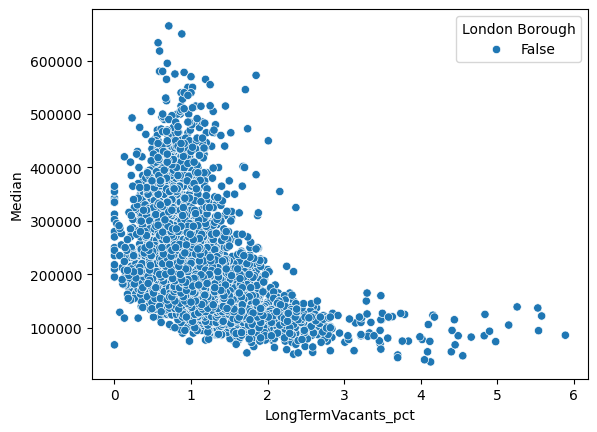

In [30]:
sns.scatterplot(data=merged, x='LongTermVacants_pct', y='Median', hue='London Borough')

<Axes: xlabel='AllVacants_pct', ylabel='Median'>

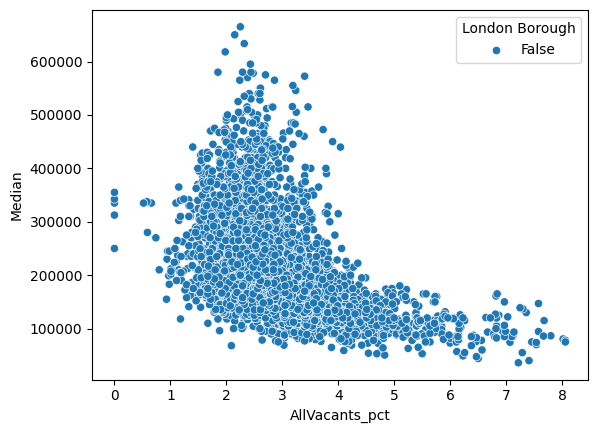

In [31]:
sns.scatterplot(data=merged, x='AllVacants_pct', y='Median', hue='London Borough')

In [32]:
from scipy import stats
x, y = merged['AllVacants_pct'], merged['Median']
res = stats.pearsonr(x, y)
res

PearsonRResult(statistic=np.float64(-0.49803394218636776), pvalue=np.float64(0.0))

In [33]:
x, y = merged['LongTermVacants_pct'], merged['Median']
res = stats.pearsonr(x, y)
res

PearsonRResult(statistic=np.float64(-0.4627177167608708), pvalue=np.float64(9.687328796893095e-291))